## Import

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Tạo hàm thiết lập giá trị của các biên

In [ ]:
# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

# Define boundary condition
def fun_u_b(x, y):
    x = x[0]
    y = y[0]
    if (x == 0) or (y == 0):
      return 0 
    elif x == 1:
      return -np.sin(np.pi)*np.sin(y)
    elif y == 1:
      return -np.sin(np.pi*x)*np.sin(np.pi*1)

## Tạo mẫu dữ liệu để train

In [ ]:
# Set number of data points
N_0 = 5000
N_b = 5000
N_bxy = 2500
N_r = 70000

# Set boundary
xmin = 0.
xmax = 1.
ymin = 0.
ymax = 1.

# Lower bounds
lb = tf.constant([xmin, ymin], dtype=DTYPE)
# Upper bounds
ub = tf.constant([xmax, ymax], dtype=DTYPE)       

# Set random seed for reproducible results
tf.random.set_seed(0)

# Boundary data
bernoulli = tf.keras.backend.random_bernoulli((N_bxy,1), 0.5, dtype=DTYPE)
uniform = tf.random.uniform((N_bxy,1), lb[0], ub[0], dtype=DTYPE)
x_b = np.vstack((bernoulli, uniform))
y_b = np.vstack((uniform, bernoulli))
XY_b = tf.concat([x_b, y_b], axis=1)

# Evaluate boundary condition at (t_b,x_b)
u_b = fun_u_b(x_b, y_b)

# Draw uniformly sampled collocation points
x_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
y_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
XY_r = tf.concat([x_r, y_r], axis=1)

# Collect boundary and inital data in lists
XY_data = [XY_b]
u_data = [u_b]

In [ ]:
# Define model architecture
class PINN_NeuralNet(tf.keras.Model):
    """ Set basic architecture of the PINN model."""

    def __init__(self, lb, ub, 
            output_dim=1,
            num_hidden_layers=8, 
            num_neurons_per_layer=20,
            activation='tanh',
            kernel_initializer='glorot_normal',
            **kwargs):
        super().__init__(**kwargs)

        self.num_hidden_layers = num_hidden_layers
        self.output_dim = output_dim
        self.lb = lb
        self.ub = ub
        
        # Define NN architecture
        self.scale = tf.keras.layers.Lambda(
           lambda x: 1.0*(x - lb)/(ub - lb))
        self.hidden = [tf.keras.layers.Dense(num_neurons_per_layer,
                             activation=tf.keras.activations.get(activation),
                             kernel_initializer=kernel_initializer)
                           for _ in range(self.num_hidden_layers)]
        self.out = tf.keras.layers.Dense(output_dim)
        
    def call(self, X):
        """Forward-pass through neural network."""
        Z = self.scale(X)
        Z = X
        for i in range(self.num_hidden_layers):
            Z = self.hidden[i](Z)
        return self.out(Z)

In [ ]:
import scipy.optimize

class PINNSolver():
    def __init__(self, model, X_r):
        self.model = model
        
        # Store collocation points
        self.x = X_r[:,0:1]
        self.y = X_r[:,1:2]
        
        # Initialize history of losses and global iteration counter
        self.hist = []
        self.iter = 0
    
    def get_r(self):
        
        with tf.GradientTape(persistent=True) as tape:
            # Watch variables representing t and x during this GradientTape
            tape.watch(self.x)
            tape.watch(self.y)
            
            # Compute current values u(t,x)
            u = self.model(tf.stack([self.x[:,0], self.y[:,0]], axis=1))
            
            u_x = tape.gradient(u, self.x)
            u_y = tape.gradient(u, self.y)
            
        u_xx = tape.gradient(u_x, self.x)
        u_yy = tape.gradient(u_y, self.y)
        
        del tape
        
        return self.fun_r(u_xx, u_yy, self.x, self.y)
    
    def loss_fn(self, X, u):
        
        # Compute phi_r
        r = self.get_r()
        phi_r = tf.reduce_mean(tf.square(r))
        
        # Initialize loss
        loss = phi_r

        # Add phi_0 and phi_b to the loss
        for i in range(len(X)):
            u_pred = self.model(X[i])
            loss += tf.reduce_mean(tf.square(u[i] - u_pred))
        
        return loss
    
    def get_grad(self, X, u):
        with tf.GradientTape(persistent=True) as tape:
            # This tape is for derivatives with
            # respect to trainable variables
            tape.watch(self.model.trainable_variables)
            loss = self.loss_fn(X, u)
            
        g = tape.gradient(loss, self.model.trainable_variables)
        del tape
        
        return loss, g
    
    def fun_r(self,u_xx, u_yy, x, y):
        return u_xx + u_yy + np.sin(np.pi*x)*np.sin(np.pi*y)
    
    def solve_with_TFoptimizer(self, optimizer, X, u, N=1001):
        """This method performs a gradient descent type optimization."""
        
        @tf.function
        def train_step():
            loss, grad_theta = self.get_grad(X, u)
            
            # Perform gradient descent step
            optimizer.apply_gradients(zip(grad_theta, self.model.trainable_variables))
            return loss
        
        for i in range(N):
            
            loss = train_step()
            
            self.current_loss = loss.numpy()
            self.callback()

    def solve_with_ScipyOptimizer(self, X, u, method='L-BFGS-B', **kwargs):
        """This method provides an interface to solve the learning problem
        using a routine from scipy.optimize.minimize.
        (Tensorflow 1.xx had an interface implemented, which is not longer
        supported in Tensorflow 2.xx.)
        Type conversion is necessary since scipy-routines are written in Fortran
        which requires 64-bit floats instead of 32-bit floats."""
        
        def get_weight_tensor():
            """Function to return current variables of the model
            as 1d tensor as well as corresponding shapes as lists."""
            
            weight_list = []
            shape_list = []
            
            # Loop over all variables, i.e. weight matrices, bias vectors and unknown parameters
            for v in self.model.variables:
                shape_list.append(v.shape)
                weight_list.extend(v.numpy().flatten())
                
            weight_list = tf.convert_to_tensor(weight_list)
            return weight_list, shape_list

        x0, shape_list = get_weight_tensor()
        
        def set_weight_tensor(weight_list):
            """Function which sets list of weights
            to variables in the model."""
            idx = 0
            for v in self.model.variables:
                vs = v.shape
                
                # Weight matrices
                if len(vs) == 2:  
                    sw = vs[0]*vs[1]
                    new_val = tf.reshape(weight_list[idx:idx+sw],(vs[0],vs[1]))
                    idx += sw
                
                # Bias vectors
                elif len(vs) == 1:
                    new_val = weight_list[idx:idx+vs[0]]
                    idx += vs[0]
                    
                # Variables (in case of parameter identification setting)
                elif len(vs) == 0:
                    new_val = weight_list[idx]
                    idx += 1
                    
                # Assign variables (Casting necessary since scipy requires float64 type)
                v.assign(tf.cast(new_val, DTYPE))
        
        def get_loss_and_grad(w):
            """Function that provides current loss and gradient
            w.r.t the trainable variables as vector. This is mandatory
            for the LBFGS minimizer from scipy."""
            
            # Update weights in model
            set_weight_tensor(w)
            # Determine value of \phi and gradient w.r.t. \theta at w
            loss, grad = self.get_grad(X, u)
            
            # Store current loss for callback function            
            loss = loss.numpy().astype(np.float64)
            self.current_loss = loss            
            
            # Flatten gradient
            grad_flat = []
            for g in grad:
                grad_flat.extend(g.numpy().flatten())
            
            # Gradient list to array
            grad_flat = np.array(grad_flat,dtype=np.float64)
            
            # Return value and gradient of \phi as tuple
            return loss, grad_flat
        
        
        return scipy.optimize.minimize(fun=get_loss_and_grad,
                                       x0=x0,
                                       jac=True,
                                       method=method,
                                       callback=self.callback,
                                       **kwargs)
        
    def callback(self, xr=None):
        if self.iter % 50 == 0:
            print('It {:05d}: loss = {:10.8e}'.format(self.iter,self.current_loss))
        self.hist.append(self.current_loss)
        self.iter+=1
        
    
    def plot_solution(self, **kwargs):
        N = 200
        xspace = np.linspace(self.model.lb[0], self.model.ub[0], N+1)
        yspace = np.linspace(self.model.lb[1], self.model.ub[1], N+1)
        X, Y = np.meshgrid(xspace, yspace)
        Xgrid = np.vstack([X.flatten(),Y.flatten()]).T
        upred = self.model(tf.cast(Xgrid,DTYPE))
        U = upred.numpy().reshape(N+1,N+1)
        fig = plt.figure(figsize=(9,6))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(X, Y, U, cmap='cividis', **kwargs)
        ax.set_xlabel('$y$')
        ax.set_ylabel('$x$')
        ax.set_zlabel('$u_\\theta(y,x)$')
        ax.view_init(35,35)
        return ax
        
    def plot_loss_history(self, ax=None):
        if not ax:
            fig = plt.figure(figsize=(7,5))
            ax = fig.add_subplot(111)
        ax.semilogy(range(len(self.hist)), self.hist,'k-')
        ax.set_xlabel('$n_{epoch}$')
        ax.set_ylabel('$\\phi^{n_{epoch}}$')
        return ax

In [ ]:
import time
# Initialize model
model = PINN_NeuralNet(lb, ub)
model.build(input_shape=(None,2))

# Initilize PINN solver
solver = PINNSolver(model, XY_r)

# Decide which optimizer should be used
#mode = 'TFoptimizer'
mode = 'ScipyOptimizer'

# Start timer
t0 = time.time()

if mode == 'TFoptimizer':
    # Choose optimizer
    lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])
    optim = tf.keras.optimizers.Adam(learning_rate=lr)
    solver.solve_with_TFoptimizer(optim, XY_data, u_data, N=4001)
    
elif mode == 'ScipyOptimizer':
    solver.solve_with_ScipyOptimizer(XY_data, u_data,
                            method='L-BFGS-B',
                            options={'maxiter': 5000,
                                     'maxfun': 5000,
                                     'maxcor': 10,
                                     'maxls': 10,
                                     'ftol': 1.0*np.finfo(float).eps})

# Print computation time
print('\nComputation time: {} seconds'.format(time.time()-t0))

It 00000: loss = 1.10958606e-01
It 00050: loss = 3.94091569e-03
It 00100: loss = 1.40204560e-03
It 00150: loss = 4.67676815e-04
It 00200: loss = 2.60001660e-04
It 00250: loss = 1.11089568e-04
It 00300: loss = 8.53482197e-05
It 00350: loss = 4.72657739e-05
It 00400: loss = 3.50394002e-05
It 00450: loss = 2.61765163e-05
It 00500: loss = 1.87599544e-05
It 00550: loss = 1.30772041e-05
It 00600: loss = 1.07973319e-05
It 00650: loss = 9.57565044e-06
It 00700: loss = 8.24589551e-06
It 00750: loss = 7.11389384e-06
It 00800: loss = 4.82862333e-06
It 00850: loss = 4.12876716e-06
It 00900: loss = 3.36405810e-06
It 00950: loss = 2.92446771e-06
It 01000: loss = 2.62119102e-06
It 01050: loss = 2.42297619e-06
It 01100: loss = 2.31159652e-06
It 01150: loss = 1.87456089e-06
It 01200: loss = 1.68463703e-06
It 01250: loss = 1.60142713e-06
It 01300: loss = 1.49416019e-06
It 01350: loss = 1.38827147e-06
It 01400: loss = 1.28754436e-06
It 01450: loss = 1.18416551e-06
It 01500: loss = 1.13367605e-06

Computa

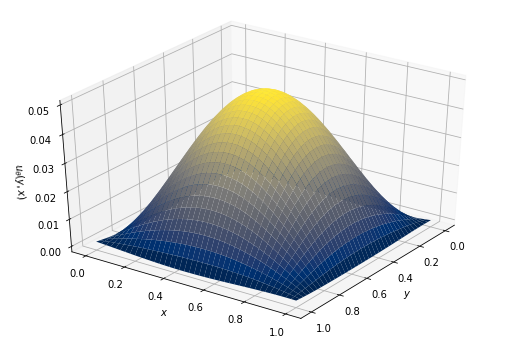

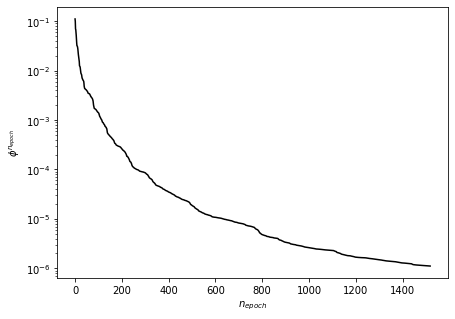

In [ ]:
solver.plot_solution();
solver.plot_loss_history();

In [ ]:
def u_exact(x ,y):
  return (np.sin(np.pi*x)*np.sin(np.pi*y))/(2*np.pi*np.pi)

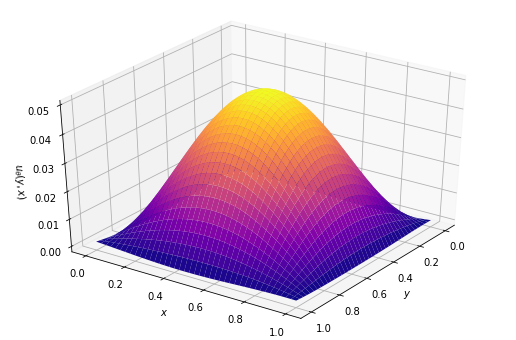

In [ ]:
N = 200
xspace = np.linspace(lb[0], ub[0], N+1)
yspace = np.linspace(lb[1], ub[1], N+1)
X, Y = np.meshgrid(xspace, yspace)
Xgrid = np.vstack([X.flatten(),Y.flatten()]).T
upred = model(tf.cast(Xgrid,DTYPE))
U = upred.numpy().reshape(N+1,N+1)
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, U, cmap='plasma')
ax.set_xlabel('$y$')
ax.set_ylabel('$x$')
ax.set_zlabel('$u_\\theta(y,x)$')
ax.view_init(35,35)

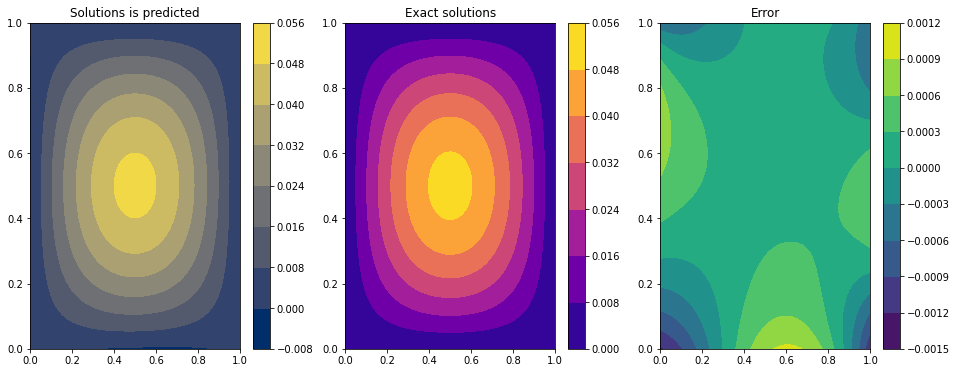

In [ ]:
fig = plt.figure(figsize=(16,6))
plt.subplot(1,3,1)
plt.title("Solutions is predicted")
cP = plt.contourf(X, Y, U, cmap='cividis')
plt.colorbar(cP)
U_exact = u_exact(X, Y)
plt.subplot(1,3,2)
plt.title("Exact solutions")
cP = plt.contourf(X,Y, U_exact, cmap='plasma')
plt.colorbar(cP)
Error = U_exact - U
plt.subplot(1,3,3)
plt.title("Error")
cP = plt.contourf(X,Y, Error, cmap='viridis')
plt.colorbar(cP)

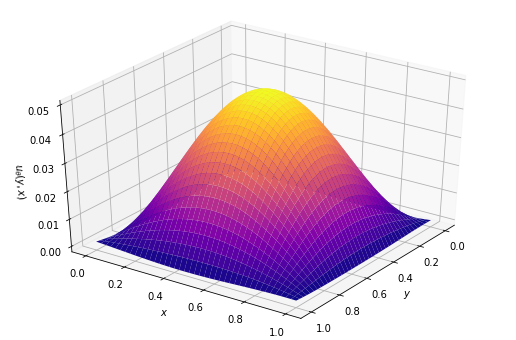

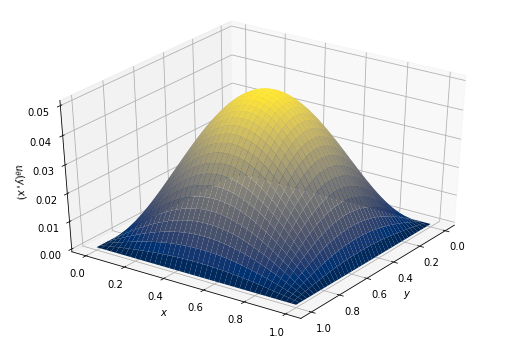

In [ ]:
upred = model(tf.cast(Xgrid,DTYPE))
U = upred.numpy().reshape(N+1,N+1)
U_exact = u_exact(X, Y)
U_list = [U, U_exact]
cmap_list = ["plasma", "cividis"]
for u in range(len(U_list)):
  fig = plt.figure(figsize=(9,6))
  ax = fig.add_subplot(111, projection='3d')
  #ax.plot_surface(X, Y, U, cmap='plasma')
  ax.plot_surface(X, Y, U_list[u], cmap=cmap_list[u])
  ax.set_xlabel('$y$')
  ax.set_ylabel('$x$')
  ax.set_zlabel('$u_\\theta(y,x)$')
  ax.view_init(35,35)

In [ ]:
model(np.array([[0.5,0.5]]))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.05044024]], dtype=float32)>

In [ ]:
u_exact(0.5 ,0.5)

0.05066059182116889

In [ ]:
# Xem độ lỗi giữa nghiệm dự đoán và nghiệm chính xác
lx = [0.345, 0.534, 0.845, 0.765]
ly = [0.523, 0.34, 0.645, 0.265]
for i in range(4):
    pred = model(np.array([[lx[i], ly[i]]]))
    u = u_exact(lx[i], ly[i])
    error = u - pred
    print(f"x {lx[i]} y {ly[i]}       pred {pred}     u_exact {u}       error {error}")

x 0.345 y 0.523       pred [[0.04442906]]     u_exact 0.04465526268994679       error [[0.00022621]]
x 0.534 y 0.34       pred [[0.04385879]]     u_exact 0.044141203091261315       error [[0.00028242]]
x 0.845 y 0.645       pred [[0.02114843]]     u_exact 0.021288283686434116       error [[0.00013985]]
x 0.765 y 0.265       pred [[0.02494096]]     u_exact 0.025217879160718812       error [[0.00027692]]
